# Лабораторная работа 4. Основы анализа данных Pandas II. 

Проверим, если зимой холодно тепло ли летом. 
Будем использовать статистические данные по погоде в Москве. 
С помощью открытых данных и математической статистики проверим сформулированную выше «народную примету», но и получим довольно неожиданную информацию о связи погоды в разные месяцы, а также своими глазами посмотрим на глобальное потепление.
Чтобы проверить эту гипотезу, нам потребуется вычислить среднюю температуру за каждый из интересующих нас месяцев каждого из 50 лет и вычислить величину, которая называется коэффициентом корреляции Пирсона. К счастью, нам даже не нужно знать, по какой формуле её считать (хотя это и полезно), поскольку Python посчитаёт её за нас. Самое главное — подготовить для этого данные.


Часть 1. Грузим данные
Возможно, необходимо будет установить дополнительно пакеты.  LXML (для Windows используйте неофициальные пакеты http://www.lfd.uci.edu/~gohlke/pythonlibs/#lxml), html5lib, BeautifulSoup4

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
dat = pd.read_html("weather.html", header=0)

Параметр header=0 показывает, что нулевая (то есть первая) строчка должна использоваться как строка заголовков (имён переменных).
На html-страничке ведь может быть несколько таблиц. pd.read_html каждую из них поместит в свой dataframe и создаст список dataframe'ов.
Узнаем количество элементов. 

In [50]:
len(dat)

1

В нём всего один элемент. Извлечём его из списка и назовём тем же именем, что раньше называли список. (Сам список нам больше не понадобится.)

In [51]:
dat = dat[0]
dat.head(3)

STATION_ID   STATION_NM    DATE_OBS  TMPMAX  Q  TMPMIN  Q.1  TMPMN  Q.2  \
0       27612  МОСКВА ВДНХ  1948-01-01     NaN  9     NaN    9    NaN    9   
1       27612  МОСКВА ВДНХ  1948-01-02     NaN  9     NaN    9    NaN    9   
2       27612  МОСКВА ВДНХ  1948-01-03     NaN  9     NaN    9    NaN    9   

   PRECIP  Q.3  D  
0     NaN    9  9  
1     NaN    9  9  
2     NaN    9  9

Теперь в dat лежит честный dataframe. Часть столбцов имеют понятный без специальных пояснений смысл: TMPMAX — максимальная температура за день, TMPMIN — минимальная, TMPMN — средняя (от слова mean), PRECIP — уровень осадков (precipitation). Ещё есть непонятные столбцы Q и D, значения которых не известны. Название и идентификатор станции нам тоже не слишком нужны. От них можно избавиться, например, вот так.

In [52]:
dat.drop(['STATION_ID', 'STATION_NM', 'Q','Q.1','Q.2','Q.3','D'],inplace=True,axis=1)

Параметр axis=1 означает, что нужно выкинуть столбцы, а не строки, inplace=True означает, что это нужно сделать «на месте», то есть модифицировать dataframe, а не вернуть его версию.

In [53]:
dat.head()

DATE_OBS  TMPMAX  TMPMIN  TMPMN  PRECIP
0  1948-01-01     NaN     NaN    NaN     NaN
1  1948-01-02     NaN     NaN    NaN     NaN
2  1948-01-03     NaN     NaN    NaN     NaN
3  1948-01-04     NaN     NaN    NaN     NaN
4  1948-01-05     NaN     NaN    NaN     NaN

В строчках за 1948 год нет никаких полезных данных и их надо бы выкинуть. Проще всего это сделать с помощью .dropna — это команда, выкидывающая строки (или столбцы, если вызывать с axis=1), в которых есть неопределенные ячейки (например, содержащие NaN).

In [54]:
dat.dropna(inplace=True)
dat.head()

DATE_OBS  TMPMAX  TMPMIN  TMPMN  PRECIP
345  1948-12-11     2.4    -4.5   -1.1     0.0
346  1948-12-12     1.9    -8.7   -6.2     0.5
347  1948-12-13    -7.4   -12.3  -10.1     0.0
348  1948-12-14    -5.6   -13.2   -9.4     0.0
349  1948-12-15    -3.6    -9.2   -6.6     0.0

Как видимо, 1948 год начинается не с начала и в нём есть только кусок декабря, так что мы его тоже, пожалуй, выкинем, от греха подальше. Я это сделал, просмотрев табличку вручную и заметив номер нужной мне строчки.

In [55]:
dat.loc[365:370]
#Не весь декабрь
dat.loc[366:370]

DATE_OBS  TMPMAX  TMPMIN  TMPMN  PRECIP
366  1949-01-01    -2.1    -6.7   -4.2     0.0
367  1949-01-02    -0.5    -6.7   -1.2     4.2
368  1949-01-03     1.1    -2.1   -0.7     0.0
369  1949-01-04     3.3     0.9    2.3     0.0
370  1949-01-05     4.0    -0.9    1.1     0.8

In [56]:
dat.drop(range(345,366),inplace=True)
dat.head()

DATE_OBS  TMPMAX  TMPMIN  TMPMN  PRECIP
366  1949-01-01    -2.1    -6.7   -4.2     0.0
367  1949-01-02    -0.5    -6.7   -1.2     4.2
368  1949-01-03     1.1    -2.1   -0.7     0.0
369  1949-01-04     3.3     0.9    2.3     0.0
370  1949-01-05     4.0    -0.9    1.1     0.8

Часть 2.Рисуем. Чтобы убедиться, что всё в порядке, нарисуем несколько картинок.

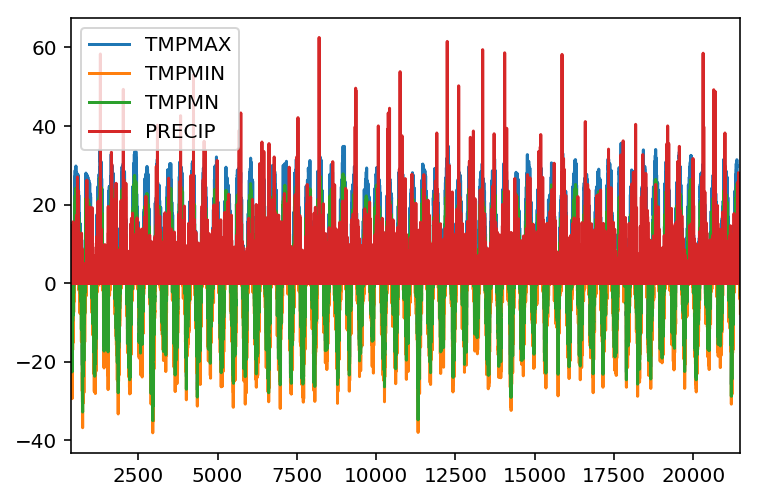

In [57]:
#Импортировал раньше пандаса выше, иначе error
dat.plot();

Что-нибудь видно? Не очень. Это потому, что мы попытались вывести на одном графике четыре разных параметра, да ещё и за кучу лет. Давайте возьмём поменьше данных для визуализации.

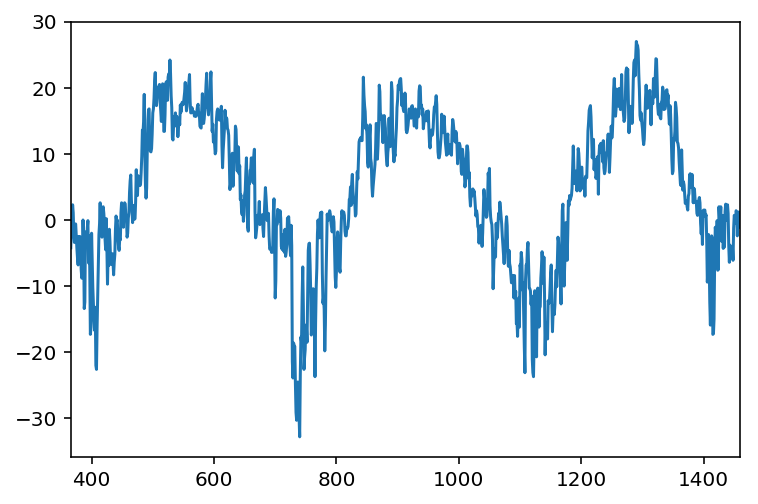

In [58]:
# только средняя температура и данные за три года
dat.iloc[0:365*3]['TMPMN'].plot();

Это график температуры за первые три года наблюдений.

Посмотрим, что происходит в масштабе десятилетий.

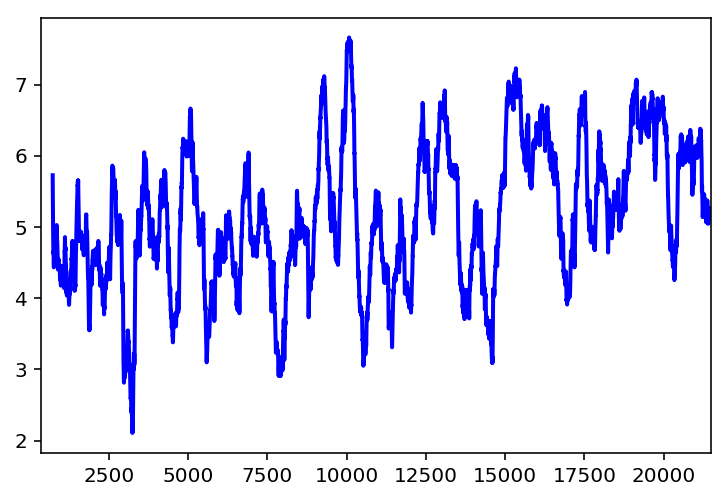

In [59]:
#pd.rolling_mean(dat['TMPMN'],365).plot(lw=2,color='blue');
dat['TMPMN'].rolling(365).mean().plot(lw=2,color='blue');

Здесь было сглаживание по годам.

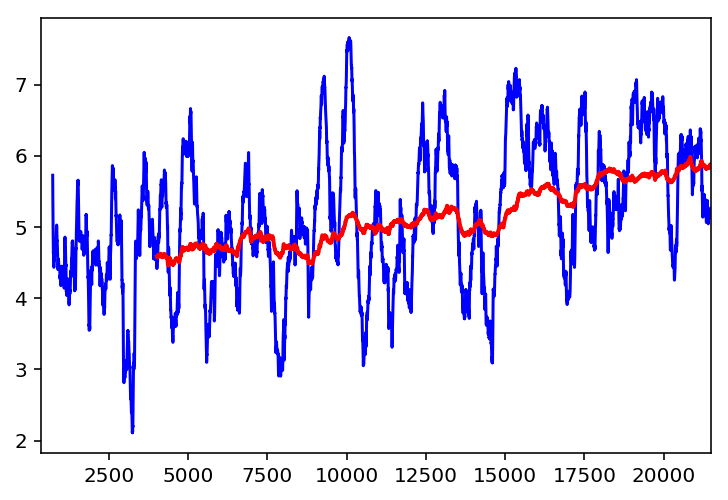

In [60]:
#pd.rolling_mean(dat['TMPMN'],365).plot(color='blue')
#pd.rolling_mean(dat['TMPMN'],3650).plot(lw=2,color='red');
dat['TMPMN'].rolling(365).mean().plot(color='blue');
dat['TMPMN'].rolling(3650).mean().plot(lw=2,color='red');

Сглаживание по годам и десятилетиям на одной картинке.

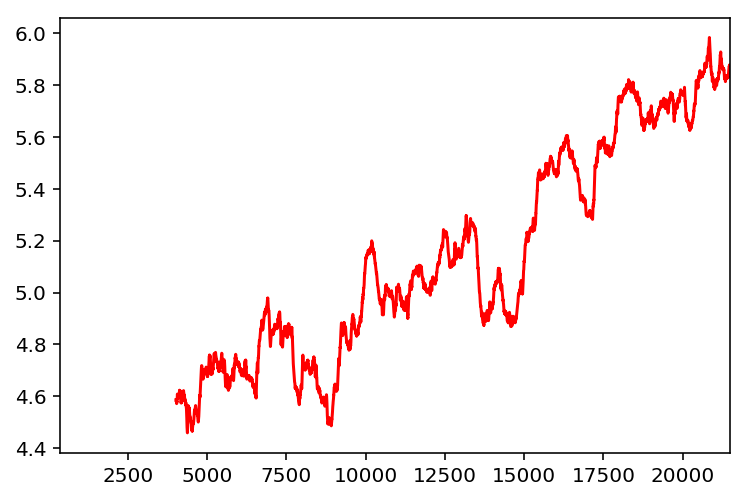

In [61]:
#pd.rolling_mean(dat['TMPMN'],3650).plot(color='red');
dat['TMPMN'].rolling(3650).mean().plot(color='red');

И, наконец, красный график отдельно. Если вас когда-нибудь интресовал вопрос о том, есть или нет глобальное потепление, то теперь, наверное, он отпал. (Вообще-то такого вопроса нет: климат меняется и действительно теплеет; вопрос, который широко обсуждается — является ли это результатом действий человека или это естественный процесс. Но на него мы так сходу не ответим.)

Часть 3. Упорядочиваем

Картинки красивые, но по горизонтальной оси написана какая-то ерунда. Это потому, что строчки сейчас индексируются числами (да ещё и отсчёт начинается с 367). Для более разумного поведения было бы хорошо индексировать строчки датами из колонки DATE_OBS. В нашем случае проблема осложняется тем, что система не воспринимает эту колонку как колонку с датами. Давайте же решим эту проблему.

In [62]:
dat['DATE_OBS'] = pd.to_datetime(dat['DATE_OBS'])
dat['DATE_OBS']

366     1949-01-01
367     1949-01-02
368     1949-01-03
369     1949-01-04
370     1949-01-05
371     1949-01-06
372     1949-01-07
373     1949-01-08
374     1949-01-09
375     1949-01-10
376     1949-01-11
377     1949-01-12
378     1949-01-13
379     1949-01-14
380     1949-01-15
381     1949-01-16
382     1949-01-17
383     1949-01-18
384     1949-01-19
385     1949-01-20
386     1949-01-21
387     1949-01-22
388     1949-01-23
389     1949-01-24
390     1949-01-25
391     1949-01-26
392     1949-01-27
393     1949-01-28
394     1949-01-29
395     1949-01-30
           ...    
21459   2006-10-02
21460   2006-10-03
21461   2006-10-04
21462   2006-10-05
21463   2006-10-06
21464   2006-10-07
21465   2006-10-08
21466   2006-10-09
21467   2006-10-10
21468   2006-10-11
21469   2006-10-12
21470   2006-10-13
21471   2006-10-14
21472   2006-10-15
21473   2006-10-16
21474   2006-10-17
21475   2006-10-18
21476   2006-10-19
21477   2006-10-20
21478   2006-10-21
21479   2006-10-22
21480   2006

Мы видим dtype: datetime64, что означает, что теперь типом данных являются даты. Сделаем теперь этот столбец индексом.

In [63]:
dat.index=dat['DATE_OBS']
dat.head()

DATE_OBS  TMPMAX  TMPMIN  TMPMN  PRECIP
DATE_OBS                                            
1949-01-01 1949-01-01    -2.1    -6.7   -4.2     0.0
1949-01-02 1949-01-02    -0.5    -6.7   -1.2     4.2
1949-01-03 1949-01-03     1.1    -2.1   -0.7     0.0
1949-01-04 1949-01-04     3.3     0.9    2.3     0.0
1949-01-05 1949-01-05     4.0    -0.9    1.1     0.8

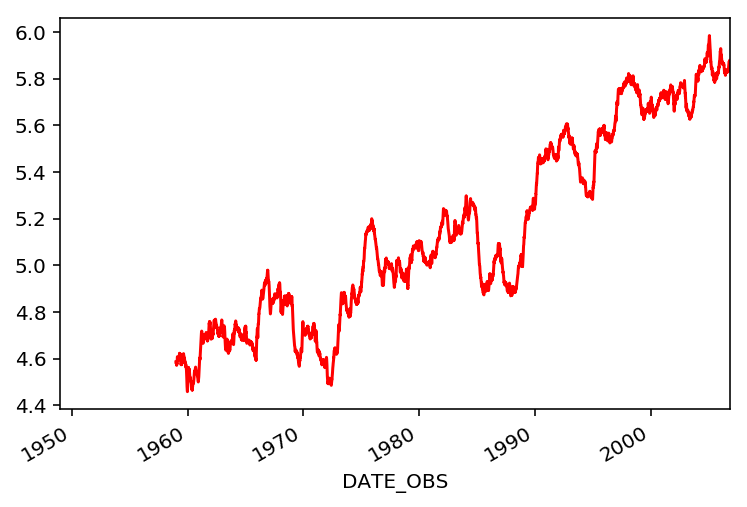

In [64]:
#pd.rolling_mean(dat['TMPMN'],3650).plot(lw=2,color='red');
dat['TMPMN'].rolling(3650).mean().plot(color='red');

Теперь вертикальная ось подписана верно. Кстати, срезы с датами тоже работают.

In [65]:
from datetime import datetime
dat[datetime(2001,1,25):datetime(2001,2,5)]

DATE_OBS  TMPMAX  TMPMIN  TMPMN  PRECIP
DATE_OBS                                            
2001-01-25 2001-01-25    -6.6   -14.8  -11.0     0.0
2001-01-26 2001-01-26    -3.5    -8.7   -5.3     0.7
2001-01-27 2001-01-27    -0.4    -4.5   -2.5     2.7
2001-01-28 2001-01-28     1.4    -0.4    0.8     3.7
2001-01-29 2001-01-29     2.9     0.8    1.4     1.1
2001-01-30 2001-01-30     1.5    -0.1    0.6     1.4
2001-01-31 2001-01-31     0.1    -1.8   -0.7     0.6
2001-02-01 2001-02-01    -1.7    -7.4   -4.5     0.0
2001-02-02 2001-02-02    -3.0   -12.3   -8.1    13.2
2001-02-03 2001-02-03    -9.3   -16.7  -13.0     2.6
2001-02-04 2001-02-04    -8.4   -16.2  -10.7    13.4
2001-02-05 2001-02-05   -11.0   -22.1  -16.0     0.9

Часть 4. Усредняем

Вернёмся к нашей задаче: верно ли, что более тёплый март — это признак того, что апрель будет более холодным? Иными словами, правда ли, что средняя температура за март и апрель отрицательно скоррелированы? Чтобы это понять, нам потребуется сформировать новую таблицу, в которой наблюдением (то есть строчкой) будет один год, а переменными (то есть столбцами) будет средняя температура за каждый месяц.

Для начала добавим в нашу таблицу столбцы, соответствующие году, месяцу и дню.

In [66]:
dat['Year']=dat.index.year
dat['Mon']=dat.index.month
dat['Day']=dat.index.day
dates=dat[['Year','Mon','Day']]
dates.head()

Year  Mon  Day
DATE_OBS                  
1949-01-01  1949    1    1
1949-01-02  1949    1    2
1949-01-03  1949    1    3
1949-01-04  1949    1    4
1949-01-05  1949    1    5

Теперь переопределим индекс более удобным для нас образом.

In [67]:
dat.index=pd.MultiIndex.from_tuples(dates.values.tolist(), names=dates.columns)

Предыдущей командой мы создали так называемый *мультииндекс*, то есть индекс с несколькими измерениями. Простейший пример мультииндекса из математики — индекс у матрицы $a_{i,j}$. Можно считать $i$ и $j$ двумя разными индексами, а можно считать пару $(i,j)$ одним мульииндексом. Мультииндекс — способ записать в обычную таблицу многомерную информацию. В данном случае у нас в мультииндексе три измерения — год, месяц, день. Вот так теперь выглядит наш dataframe.

In [68]:
dat.head()

DATE_OBS  TMPMAX  TMPMIN  TMPMN  PRECIP  Year  Mon  Day
Year Mon Day                                                          
1949 1   1   1949-01-01    -2.1    -6.7   -4.2     0.0  1949    1    1
         2   1949-01-02    -0.5    -6.7   -1.2     4.2  1949    1    2
         3   1949-01-03     1.1    -2.1   -0.7     0.0  1949    1    3
         4   1949-01-04     3.3     0.9    2.3     0.0  1949    1    4
         5   1949-01-05     4.0    -0.9    1.1     0.8  1949    1    5

Нам нужно для каждого года и каждого месяца найти среднюю температуру за этот месяц. Для этого следует сгруппировать элемены таблички по году и месяцу и к тому, что получилось, применить метод .mean().

In [69]:
year_day_mean=dat.groupby(level=[0,1]).mean()
year_day_mean.head()

TMPMAX     TMPMIN      TMPMN    PRECIP    Year  Mon   Day
Year Mon                                                              
1949 1    -1.300000  -6.493548  -3.670968  0.854839  1949.0  1.0  16.0
     2    -3.571429 -11.075000  -7.339286  0.789286  1949.0  2.0  14.5
     3     1.390323  -6.470968  -2.780645  2.419355  1949.0  3.0  16.0
     4     9.056667  -0.066667   4.280000  0.603333  1949.0  4.0  15.5
     5    21.377419   9.093548  15.225806  1.016129  1949.0  5.0  16.0

Почти то, что нужно. Теперь оставим лишь интересующий нас параметр — среднюю температуру за день (усредненную потом ещё и за месяц), то есть TMPMN.

In [70]:
tmpmn=year_day_mean['TMPMN']
tmpmn.head()

Year  Mon
1949  1      -3.670968
      2      -7.339286
      3      -2.780645
      4       4.280000
      5      15.225806
Name: TMPMN, dtype: float64

И сделаем из одномерной таблицы с мультииндексом двумерную таблицу с обычными одномерными индексами:

In [71]:
mon_mean=tmpmn.unstack()
mon_mean.head()

Mon          1          2         3         4          5          6   \
Year                                                                   
1949  -3.670968  -7.339286 -2.780645  4.280000  15.225806  16.973333   
1950 -18.022581  -6.764286 -2.225806  9.043333  11.738710  15.123333   
1951 -12.138710 -12.264286 -3.996774  8.403333   9.738710  17.706667   
1952  -4.135484  -7.096552 -9.106452  5.166667  10.358065  17.340000   
1953 -10.403226 -15.614286 -2.606452  7.183333  11.645161  19.193333   

Mon          7          8          9         10        11        12  
Year                                                                 
1949  17.425806  16.074194  11.506667  4.800000 -0.423333 -4.322581  
1950  16.177419  14.080645  11.990000  4.745161 -0.433333 -5.503226  
1951  18.590323  18.325806  11.990000  2.780645 -4.810000 -1.251613  
1952  17.870968  16.848387  12.136667  3.925806 -1.133333 -5.883871  
1953  19.025806  17.290323  10.046667  5.790323 -3.156667 -5.632258

Вот теперь совсем то, что нужно! Дадим месяцам осмысленные имена.

In [72]:
mon_mean.columns=['Jan','Feb','Mar','Apr','May','Jun','Jul',
                  'Aug','Sep','Oct','Nov','Dec']
mon_mean.head()

Jan        Feb       Mar       Apr        May        Jun  \
Year                                                                   
1949  -3.670968  -7.339286 -2.780645  4.280000  15.225806  16.973333   
1950 -18.022581  -6.764286 -2.225806  9.043333  11.738710  15.123333   
1951 -12.138710 -12.264286 -3.996774  8.403333   9.738710  17.706667   
1952  -4.135484  -7.096552 -9.106452  5.166667  10.358065  17.340000   
1953 -10.403226 -15.614286 -2.606452  7.183333  11.645161  19.193333   

            Jul        Aug        Sep       Oct       Nov       Dec  
Year                                                                 
1949  17.425806  16.074194  11.506667  4.800000 -0.423333 -4.322581  
1950  16.177419  14.080645  11.990000  4.745161 -0.433333 -5.503226  
1951  18.590323  18.325806  11.990000  2.780645 -4.810000 -1.251613  
1952  17.870968  16.848387  12.136667  3.925806 -1.133333 -5.883871  
1953  19.025806  17.290323  10.046667  5.790323 -3.156667 -5.632258

Часть 5. Считаем.
Барабанная дробь! Торжественный момент: мы наконец можем посчитать интересующие нас корреляции! Та-дам!

In [73]:
corr=mon_mean.corr()
corr

Jan       Feb       Mar       Apr       May       Jun       Jul  \
Jan  1.000000  0.384755  0.257302  0.216484  0.047153  0.039691  0.206568   
Feb  0.384755  1.000000  0.379095  0.216300  0.017000  0.028284  0.252928   
Mar  0.257302  0.379095  1.000000  0.328143  0.071455  0.177538  0.091281   
Apr  0.216484  0.216300  0.328143  1.000000  0.041331  0.017182  0.159124   
May  0.047153  0.017000  0.071455  0.041331  1.000000 -0.121644  0.028159   
Jun  0.039691  0.028284  0.177538  0.017182 -0.121644  1.000000  0.306204   
Jul  0.206568  0.252928  0.091281  0.159124  0.028159  0.306204  1.000000   
Aug -0.120758 -0.097432  0.022202 -0.117359  0.118944  0.093280  0.411425   
Sep  0.134955  0.033740 -0.081379  0.028134  0.038196 -0.060803  0.131770   
Oct  0.117936  0.071301 -0.037189  0.037973  0.178622  0.111169  0.132230   
Nov -0.142560  0.059700 -0.031521  0.077483  0.175155 -0.370548  0.000195   
Dec -0.059667 -0.012276 -0.075481  0.000211 -0.156485  0.150160  0.053797   

          Aug       Sep       Oct       Nov       Dec  
Jan -0.120758  0.134955  0.117936 -0.142560 -0.059667  
Feb -0.097432  0.033740  0.071301  0.059700 -0.012276  
Mar  0.022202 -0.081379 -0.037189 -0.031521 -0.075481  
Apr -0.117359  0.028134  0.037973  0.077483  0.000211  
May  0.118944  0.038196  0.178622  0.175155 -0.156485  
Jun  0.093280 -0.060803  0.111169 -0.370548  0.150160  
Jul  0.411425  0.131770  0.132230  0.000195  0.053797  
Aug  1.000000  0.222137  0.179547  0.123741  0.002483  
Sep  0.222137  1.000000  0.277824  0.077645  0.054884  
Oct  0.179547  0.277824  1.000000  0.146520 -0.031469  
Nov  0.123741  0.077645  0.146520  1.000000 -0.112312  
Dec  0.002483  0.054884 -0.031469 -0.112312  1.000000

На табличку с цифрами смотреть не очень приятно, так что мы лучше нарисуем картинку.

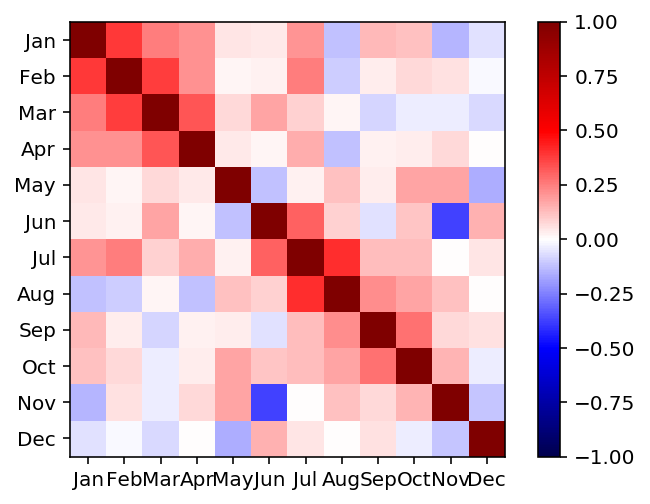

In [74]:
import matplotlib.pyplot as plt
plt.imshow(corr,cmap='seismic',interpolation='none',vmin=-1,vmax=1)
plt.colorbar()
plt.xticks(range(len(corr)),corr.columns)
plt.yticks(range(len(corr)),corr.columns);

Красные квадратики означают положительную корреляцию, синие — отрицательную. Как видим, исходное утверждение «если март тёплый, то апрель будет холодным», подтвердилось с точностью до наоборот — корреляция положительная. А вот между июнем и ноябрём — отрицательная. (Интересно, почему так? Это действительно есть такой эффект или просто артефакт наших данных?)

Проиллюстрируем утверждение о корреляциях на графиках, которые называются точечными диаграммами или диаграммами рассеяния (scatter plot).

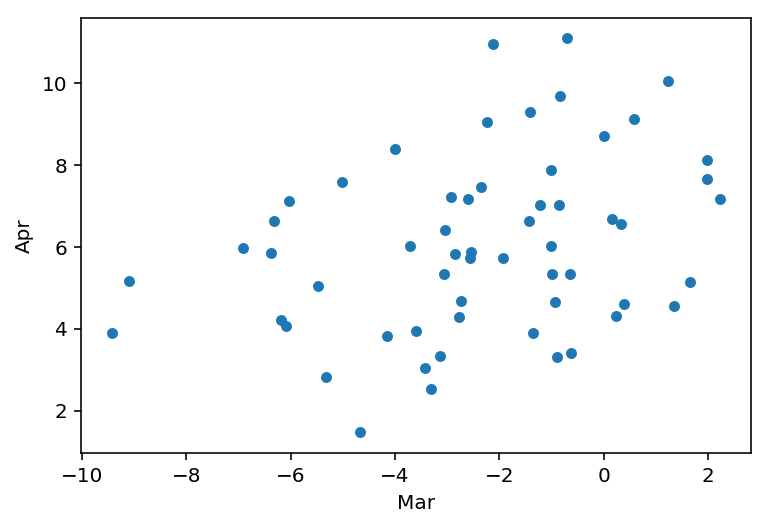

In [75]:
mon_mean.plot(kind='scatter',x='Mar',y='Apr');

Каждая точка на графике — это один год, по горизонтальной оси отмечена средняя температура за март, а по вертикальной — за апрель. Видно, что график немного вытянут вдоль диагонали, которая идёт «из левого нижнего угла в правый верхний» — это и соответствует наличию положительной корреляции.

А вот аналогичный график для пары июнь — ноябрь:

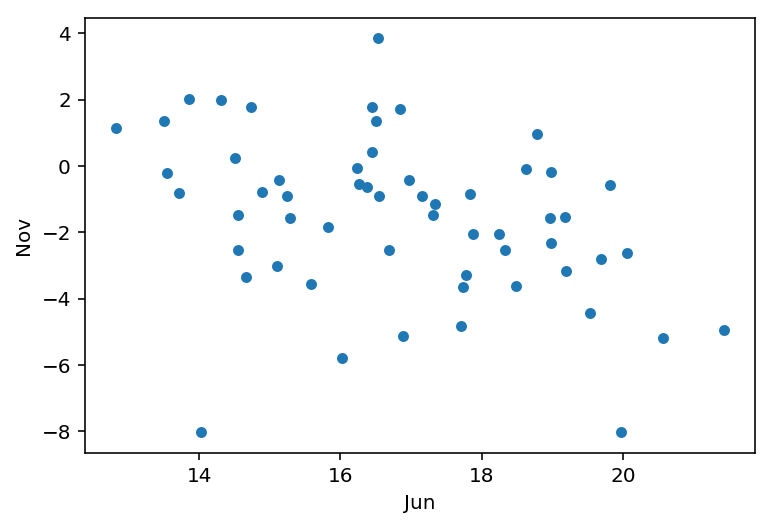

In [76]:
mon_mean.plot(kind='scatter',x='Jun',y='Nov');

На сколько градусов растёт в среднем температура за один год? (Посчитать регрессию с помощью statsmodels.)

c:\users\neyw4\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(1, -1)

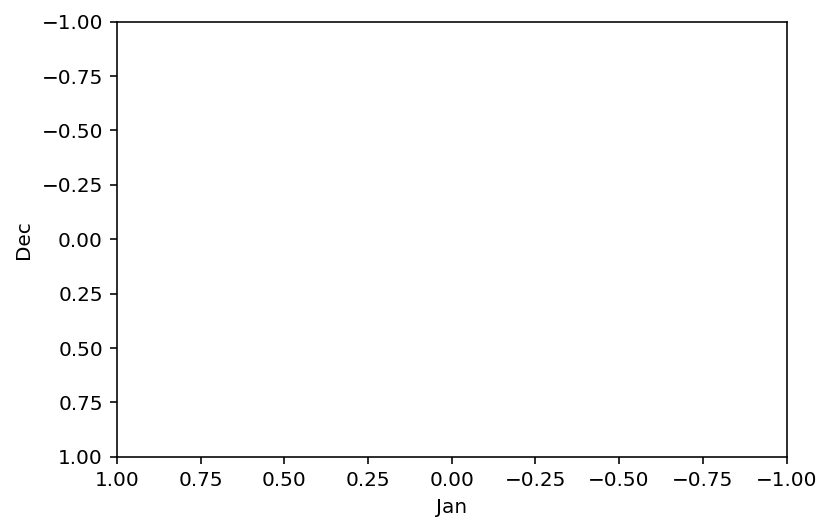

In [77]:
import statsmodels.api as sm
import numpy as np
model = sm.OLS(mon_mean.Dec, sm.add_constant(mon_mean.Jan))
p = model.fit().params

x = np.arange(1, 3)


ax = mon_mean.plot(kind='scatter',x='Jan', y='Dec')

ax.plot(x, p.const + p.Jan * x)
ax.set_xlim([1, -1])
ax.set_ylim([1, -1])
#прогрессия отсутствует?


Известна поговорка «после дождичка в четверг» (о маловероятном событии). Проверить с помощью теста Стьюдента, отличается ли статистически значимо уровень осадков (PRECIP), выпадающих по четвергам, от уровня осадков в остальные дни недели? (dat.index.weekday.)

In [79]:
dat['weekday'] = dat['DATE_OBS'].dt.dayofweek
dat
#Monday=0, Sunday=6

DATE_OBS  TMPMAX  TMPMIN  TMPMN  PRECIP  Year  Mon  Day  \
Year Mon Day                                                             
1949 1   1   1949-01-01    -2.1    -6.7   -4.2     0.0  1949    1    1   
         2   1949-01-02    -0.5    -6.7   -1.2     4.2  1949    1    2   
         3   1949-01-03     1.1    -2.1   -0.7     0.0  1949    1    3   
         4   1949-01-04     3.3     0.9    2.3     0.0  1949    1    4   
         5   1949-01-05     4.0    -0.9    1.1     0.8  1949    1    5   
         6   1949-01-06    -0.8    -3.2   -2.3     0.0  1949    1    6   
         7   1949-01-07    -0.6    -5.1   -3.4     0.0  1949    1    7   
         8   1949-01-08     0.5    -3.0   -0.6     1.7  1949    1    8   
         9   1949-01-09     0.8    -1.6   -0.6     0.0  1949    1    9   
         10  1949-01-10    -1.1    -4.2   -2.5     1.6  1949    1   10   
         11  1949-01-11    -3.0    -5.3   -4.3     0.0  1949    1   11   
         12  1949-01-12    -3.3    -8.4   -5.8     0.0  1949    1   12   
         13  1949-01-13    -4.8   -10.2   -6.8     0.2  1949    1   13   
         14  1949-01-14    -1.0    -5.7   -2.5     0.0  1949    1   14   
         15  1949-01-15    -1.9    -3.2   -2.9     2.2  1949    1   15   
         16  1949-01-16    -0.5    -4.9   -2.5     0.9  1949    1   16   
         17  1949-01-17    -0.7    -4.0   -3.2     0.1  1949    1   17   
         18  1949-01-18    -3.8   -10.3   -7.5     0.0  1949    1   18   
         19  1949-01-19    -6.9   -10.4   -8.8     0.2  1949    1   19   
         20  1949-01-20    -2.4   -13.5   -8.6     2.5  1949    1   20   
         21  1949-01-21     1.6    -2.6    0.0     3.6  1949    1   21   
         22  1949-01-22     0.2   -11.7   -4.2     2.0  1949    1   22   
         23  1949-01-23   -11.4   -15.5  -13.4     0.0  1949    1   23   
         24  1949-01-24   -10.5   -14.4  -12.4     0.0  1949    1   24   
         25  1949-01-25     1.7   -11.5   -1.8     4.4  1949    1   25   
         26  1949-01-26    -0.7    -6.8   -3.1     0.0  1949    1   26   
         27  1949-01-27     1.1    -9.1   -3.7     0.0  1949    1   27   
         28  1949-01-28     1.2    -2.6   -1.2     0.0  1949    1   28   
         29  1949-01-29     1.4    -2.6   -0.1     0.0  1949    1   29   
         30  1949-01-30    -0.5    -8.1   -6.5     0.0  1949    1   30   
...                 ...     ...     ...    ...     ...   ...  ...  ...   
2006 10  2   2006-10-02    13.6     7.2   10.0     0.0  2006   10    2   
         3   2006-10-03    14.7    10.9   12.5    10.2  2006   10    3   
         4   2006-10-04    14.3    10.3   12.6     4.9  2006   10    4   
         5   2006-10-05    15.9    11.6   13.7     3.8  2006   10    5   
         6   2006-10-06    14.0     9.0   11.1     0.0  2006   10    6   
         7   2006-10-07    13.9     7.9   10.3     0.0  2006   10    7   
         8   2006-10-08    14.4     7.1   10.8     3.0  2006   10    8   
         9   2006-10-09    12.3     9.9   10.9     2.5  2006   10    9   
         10  2006-10-10    11.5     8.5    9.8     0.6  2006   10   10   
         11  2006-10-11     9.0     6.0    7.0     0.0  2006   10   11   
         12  2006-10-12     8.7     0.4    5.3     2.2  2006   10   12   
         13  2006-10-13     9.8     5.1    7.6     0.0  2006   10   13   
         14  2006-10-14     7.9     4.7    5.8     1.2  2006   10   14   
         15  2006-10-15     4.8    -1.4    1.3     2.1  2006   10   15   
         16  2006-10-16     0.8    -1.7   -0.4     0.0  2006   10   16   
         17  2006-10-17     2.9    -4.1    0.0     0.0  2006   10   17   
         18  2006-10-18     5.4    -1.0    2.2     0.1  2006   10   18   
         19  2006-10-19     7.1     3.8    5.5     0.6  2006   10   19   
         20  2006-10-20     4.4     2.3    3.5     0.7  2006   10   20   
         21  2006-10-21     4.1     0.5    1.9     3.7  2006   10   21   
         22  2006-10-22    12.0     3.9    8.8     0.7  2006   10   22   
         23  2006-1

Часть 6. Дополните данными с 2007 по 2017 год для Москвы с файла lab4_moscow07-16. 


In [80]:
dat = pd.read_csv("lab4_moscow07-16.csv", sep=';', encoding='ANSI', header=6)
#pd.read_csv?

c:\users\neyw4\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (21,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [81]:
dat.head()

Местное время в Москве (ВДНХ)      T     Po    P    Pa  \
19.10.2016 21:00                            1.9  760.6  775.6  0.0  79.0   
19.10.2016 18:00                            1.9  760.6  775.6 -0.1  80.0   
19.10.2016 15:00                            2.5  760.7  775.7 -0.3  72.0   
19.10.2016 12:00                            2.2  761.0  776.1  0.1  76.0   
19.10.2016 09:00                            1.9  760.9  775.9  0.3  80.0   

                                                      U   DD  Ff  ff10    ff3  \
19.10.2016 21:00         Ветер, дующий с северо-востока  1.0 NaN   NaN  100%.   
19.10.2016 18:00          Ветер, дующий с северо-запада  1.0 NaN   NaN  100%.   
19.10.2016 15:00  Ветер, дующий с северо-северо-востока  1.0 NaN   NaN  100%.   
19.10.2016 12:00   Ветер, дующий с северо-северо-запада  1.0 NaN   NaN  100%.   
19.10.2016 09:00  Ветер, дующий с северо-северо-востока  1.0 NaN   NaN  100%.   

                  ...   Cm    Ch   VV             Td   RRR  \
19.10.2016 21:00  ...  NaN   NaN -1.4    Осадков нет  12.0   
19.10.2016 18:00  ...  NaN   NaN -1.3  Следы осадков  12.0   
19.10.2016 15:00  ...  NaN  10.0 -2.1            NaN   NaN   
19.10.2016 12:00  ...  NaN  10.0 -1.7            NaN   NaN   
19.10.2016 09:00  ...  NaN  10.0 -1.2  Следы осадков  12.0   

                                          tR    E   Tg   E' sss  
19.10.2016 21:00                         NaN  NaN  NaN  NaN NaN  
19.10.2016 18:00                         NaN  NaN  NaN  NaN NaN  
19.10.2016 15:00                         NaN  NaN  NaN  NaN NaN  
19.10.2016 12:00                         NaN  NaN  NaN  NaN NaN  
19.10.2016 09:00  Поверхность почвы влажная.  3.0  NaN  NaN NaN  

[5 rows x 29 columns]

Постройте аналогичную таблицу корреляции для этих годов. 

In [82]:
dat.drop(["Местное время в Москве (ВДНХ)","U","DD","Ff","ff10","ff3","N","WW","W1","W2","Tn","Tx","Cl","Nh","H","Cm","Ch","VV","Td","RRR","tR","E","Tg","E'","sss"],inplace=True,axis=1)
dat.head()

T     Po    P    Pa
19.10.2016 21:00  760.6  775.6  0.0  79.0
19.10.2016 18:00  760.6  775.6 -0.1  80.0
19.10.2016 15:00  760.7  775.7 -0.3  72.0
19.10.2016 12:00  761.0  776.1  0.1  76.0
19.10.2016 09:00  760.9  775.9  0.3  80.0

Постройте картинку. 

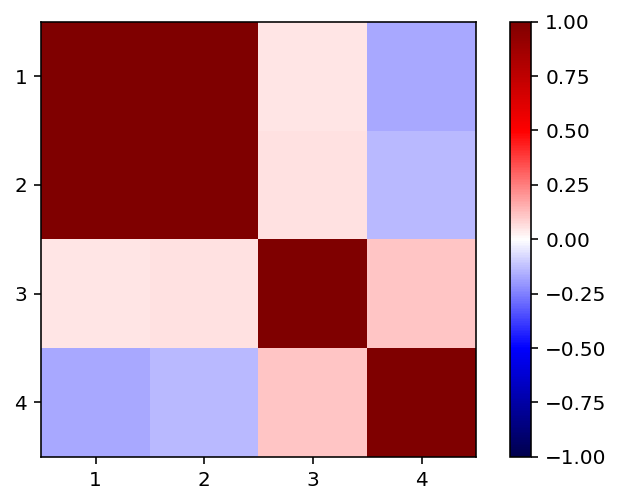

In [83]:
dat.columns=['1','2','3','4']
dat.head()
corr = dat.corr()
corr
import matplotlib.pyplot as plt
plt.imshow(corr,cmap='seismic',interpolation='none',vmin=-1,vmax=1)
plt.colorbar()
plt.xticks(range(len(corr)),corr.columns)
plt.yticks(range(len(corr)),corr.columns);

И 2 графика, аналогичным выше.

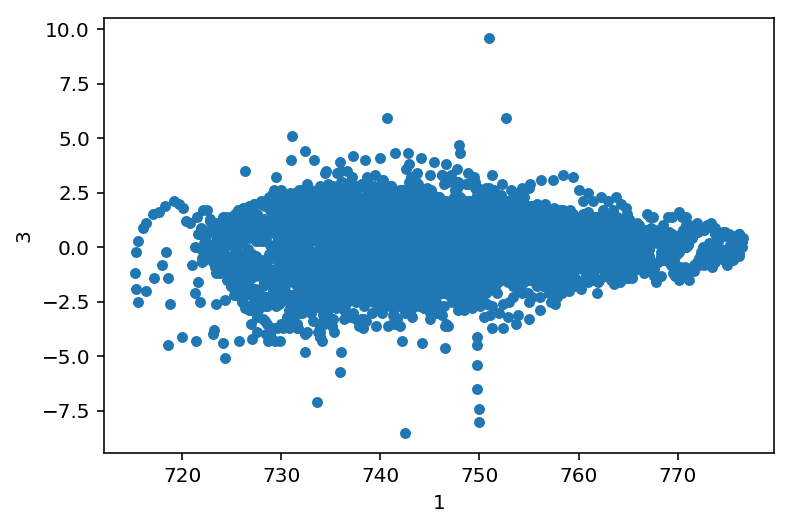

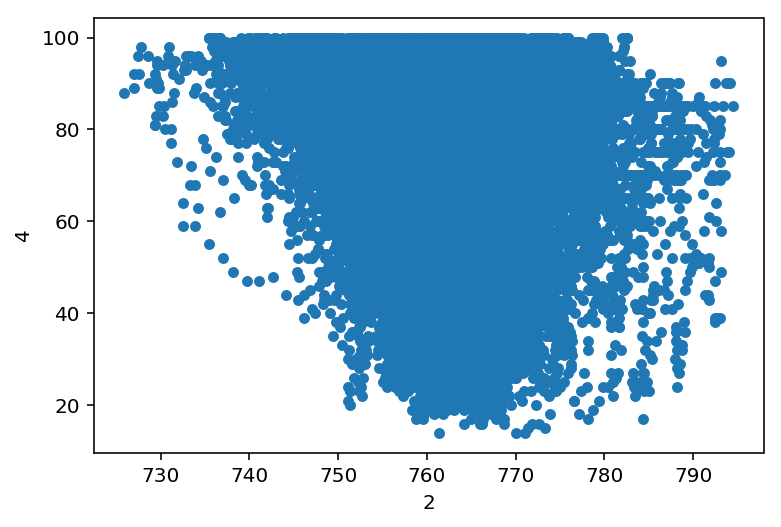

In [84]:
dat.plot(kind='scatter',x='1',y='3');
dat.plot(kind='scatter',x='2',y='4');

Сделайте вывод. 

Вывод. 

Часть 7. Сделайте все тоже самое для Гродно. Используйте файл lab4_grodno07-16.

In [85]:
dat1 = pd.read_csv("lab4_grodno07-16.csv", sep=';', encoding='ANSI', header=6)
dat1.head()

Местное время в Гродно (аэропорт)      T     Po    P    Pa  \
19.10.2016 21:00                                6.0  753.6  767.4  0.0  69.0   
19.10.2016 18:00                                7.0  753.6  767.3 -0.1  67.0   
19.10.2016 15:00                                6.4  753.7  767.5 -0.3  66.0   
19.10.2016 12:00                                4.5  754.0  767.8  0.0  79.0   
19.10.2016 09:00                                0.8  754.0  768.1 -0.4  85.0   

                                            U   DD  Ff  ff10  \
19.10.2016 21:00  Ветер, дующий с юго-востока  5.0 NaN   NaN   
19.10.2016 18:00  Ветер, дующий с юго-востока  5.0 NaN   NaN   
19.10.2016 15:00  Ветер, дующий с юго-востока  5.0 NaN   NaN   
19.10.2016 12:00  Ветер, дующий с юго-востока  5.0 NaN   NaN   
19.10.2016 09:00  Ветер, дующий с юго-востока  3.0 NaN   NaN   

                                        ff3  ...  \
19.10.2016 21:00  90  или более, но не 100%  ...   
19.10.2016 18:00                  70 – 80%.  ...   
19.10.2016 15:00                  70 – 80%.  ...   
19.10.2016 12:00                  70 – 80%.  ...   
19.10.2016 09:00                  70 – 80%.  ...   

                                                                 Cm    Ch  \
19.10.2016 21:00                                                NaN  10.0   
19.10.2016 18:00  Перистых, перисто-кучевых или перисто-слоистых...  10.0   
19.10.2016 15:00  Перистых, перисто-кучевых или перисто-слоистых...  10.0   
19.10.2016 12:00  Перистых, перисто-кучевых или перисто-слоистых...  10.0   
19.10.2016 09:00  Перистых, перисто-кучевых или перисто-слоистых...  10.0   

                   VV   Td  RRR   tR   E   Tg   E' sss  
19.10.2016 21:00  0.6  NaN  NaN  NaN NaN  NaN  NaN NaN  
19.10.2016 18:00  1.3  NaN  NaN  NaN NaN  NaN  NaN NaN  
19.10.2016 15:00  0.5  NaN  NaN  NaN NaN  NaN  NaN NaN  
19.10.2016 12:00  1.2  NaN  NaN  NaN NaN  NaN  NaN NaN  
19.10.2016 09:00 -1.5  NaN  NaN  NaN NaN  NaN  NaN NaN  

[5 rows x 29 columns]

In [86]:
dat1.drop(["Местное время в Гродно (аэропорт)","U","DD","Ff","ff10","ff3","N","WW","W1","W2","Tn","Tx","Cl","Nh","H","Cm","Ch","VV","Td","RRR","tR","E","Tg","E'","sss"],inplace=True,axis=1)
dat1.head()

T     Po    P    Pa
19.10.2016 21:00  753.6  767.4  0.0  69.0
19.10.2016 18:00  753.6  767.3 -0.1  67.0
19.10.2016 15:00  753.7  767.5 -0.3  66.0
19.10.2016 12:00  754.0  767.8  0.0  79.0
19.10.2016 09:00  754.0  768.1 -0.4  85.0

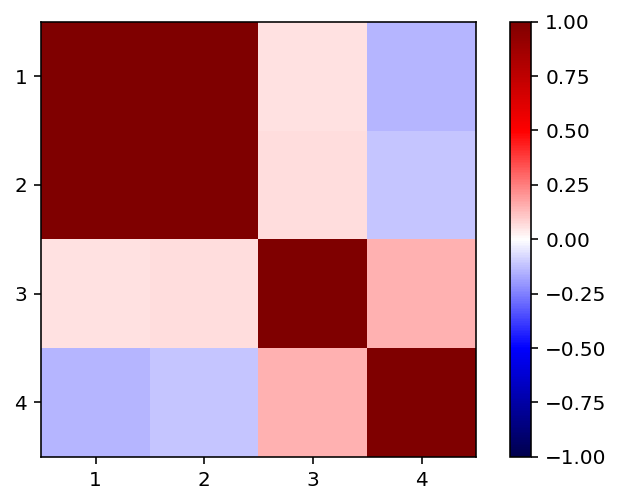

In [87]:
dat1.columns=['1','2','3','4']
dat1.head()
corr = dat1.corr()
corr
import matplotlib.pyplot as plt
plt.imshow(corr,cmap='seismic',interpolation='none',vmin=-1,vmax=1)
plt.colorbar()
plt.xticks(range(len(corr)),corr.columns)
plt.yticks(range(len(corr)),corr.columns);


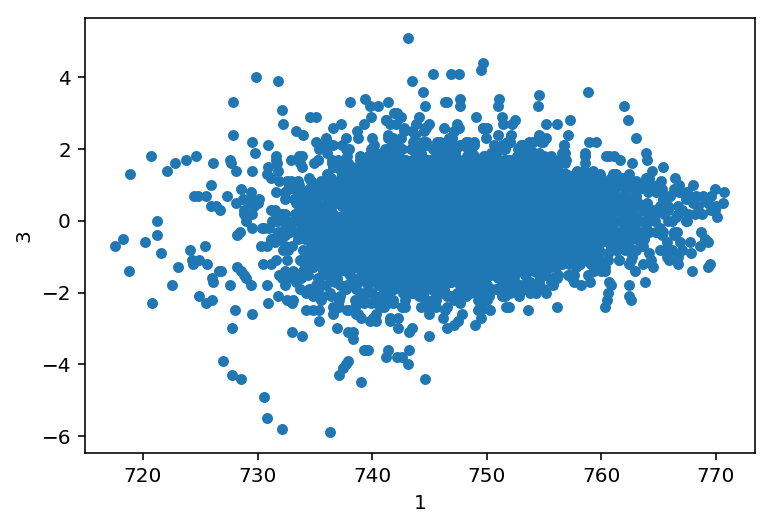

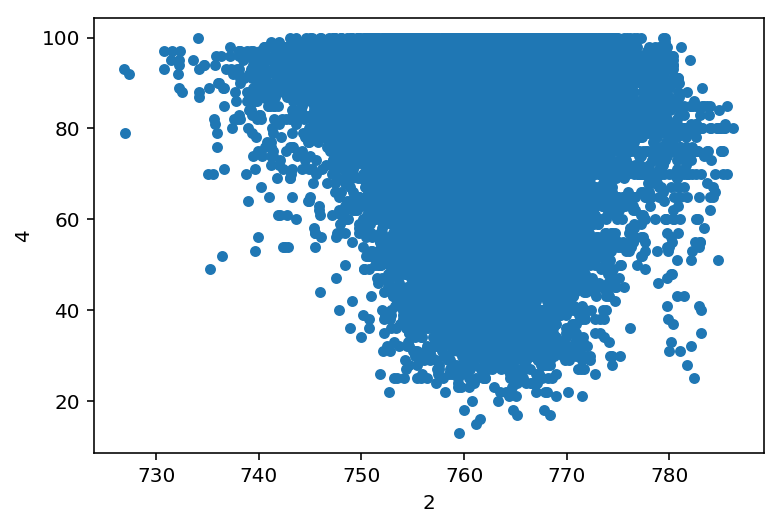

In [88]:
dat1.plot(kind='scatter',x='1',y='3');
dat1.plot(kind='scatter',x='2',y='4');

Вывод.